# Maquinas generadoras de vectores de soporte

## Imports

In [65]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Quadratic programming solver.
import cvxopt
from cvxopt import matrix

## Datos de ejemplo: monedas

In [3]:
dataset = pd.read_csv('../data/coins.csv')
dataset.head(5)

,size,weight,type
0,2.251690,2.385475,$1
1,1.942471,2.071512,$1
2,2.966826,3.316406,$5
3,2.329461,1.464435,$1
4,2.098560,2.154872,$1


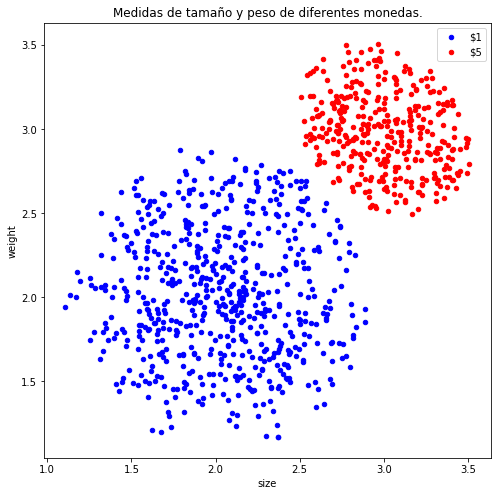

In [4]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax = dataset[dataset.type == '$1'].plot.scatter('size', 'weight', c='blue', ax=ax)
dataset[dataset.type == '$5'].plot.scatter('size', 'weight', c='red', ax=ax)
ax.legend(['$1', '$5'])
ax.set_title('Medidas de tamaño y peso de diferentes monedas.');

## Our optimization problem
Minimize w.r.t to $\alpha$ subject to $\alpha_n \geq 0$ for $n = 1, ..., N$ and  $\sum_{n=1}^N\alpha_n y_n = 0$,
$$ \mathcal{L}(\alpha) = \frac{1}{2}\sum_{n=1}^N\sum_{m=1}^N y_n y_m\alpha_n\alpha_m\mathrm{x}_n^\intercal\mathrm{x}_m  - \sum_{n=1}^N\alpha_n $$

In [13]:
#P = (ynymxnxm)
Y = dataset.type.apply(lambda x: 1 if x =='$5' else -1)
ynym = np.ndarray((len(Y), len(Y)))
for i, y_n in enumerate(Y):
    for j, y_m in enumerate(Y):
        ynym[i, j] = y_n * y_m

In [16]:
ynym

array([[ 1.,  1., -1., ..., -1.,  1., -1.],
       [ 1.,  1., -1., ..., -1.,  1., -1.],
       [-1., -1.,  1., ...,  1., -1.,  1.],
       ..., 
       [-1., -1.,  1., ...,  1., -1.,  1.],
       [ 1.,  1., -1., ..., -1.,  1., -1.],
       [-1., -1.,  1., ...,  1., -1.,  1.]])

In [39]:
X = dataset[['size', 'weight']]
xnxm = np.ndarray((len(Y), len(Y)))
for i, (ix, x_n) in enumerate(X.iterrows()):
    for j, (jx, x_m) in enumerate(X.iterrows()):
        xnxm[i, j] = np.dot(x_n, x_m)

In [41]:
xnxm

array([[ 10.76059888,   9.31538459,  14.59157576, ...,  13.35165176,
          8.6825117 ,  14.05683689],
       [  9.31538459,   8.06435894,  12.63295075, ...,  11.55492705,
          7.51984237,  12.16347245],
       [ 14.59157576,  12.63295075,  19.80060469, ...,  18.06038148,
         11.81745805,  18.99209625],
       ..., 
       [ 13.35165176,  11.55492705,  18.06038148, ...,  16.70786627,
         10.63477393,  17.66035234],
       [  8.6825117 ,   7.51984237,  11.81745805, ...,  10.63477393,
          7.1413553 ,  11.12784036],
       [ 14.05683689,  12.16347245,  18.99209625, ...,  17.66035234,
         11.12784036,  18.70156989]])

In [103]:
P = ynym * xnxm

In [104]:
#q = - (1111..)
q = - np.ones(len(Y))

In [125]:
#b = 0
b = np.zeros((1,1))

In [126]:
#G = -I
G = -np.eye(len(Y))

In [132]:
#A = (y1...yn)
A = np.zeros((1,len(Y)))
A[0] = Y

In [133]:
# h = 0
h = np.zeros((len(Y),1))

In [134]:
(matrix(P), matrix(q), matrix(G), matrix(h.T), matrix(A), matrix(b))

(<985x985 matrix, tc='d'>,
 <985x1 matrix, tc='d'>,
 <985x985 matrix, tc='d'>,
 <1x985 matrix, tc='d'>,
 <1x985 matrix, tc='d'>,
 <1x1 matrix, tc='d'>)

In [137]:
sol = cvxopt.solvers.qp(matrix(P), matrix(q), G=matrix(G), h=matrix(h), A=matrix(A), b=matrix(b))

     pcost       dcost       gap    pres   dres
 0: -1.8380e+02 -3.9121e+02  4e+03  6e+01  2e+00
 1: -3.7857e+02 -3.9786e+02  2e+03  3e+01  1e+00
 2: -4.9720e+02 -5.0877e+02  2e+03  3e+01  1e+00
 3: -8.8712e+02 -7.6169e+02  2e+03  2e+01  8e-01
 4: -1.3964e+03 -1.1848e+03  2e+03  2e+01  8e-01
 5: -4.2192e+03 -3.2284e+03  2e+03  2e+01  8e-01
 6: -1.7980e+03 -1.0131e+03  3e+03  1e+01  5e-01
 7: -6.6458e+02 -2.6950e+02  1e+03  4e+00  1e-01
 8: -1.2836e+02 -1.7277e+02  4e+01  2e-13  4e-12
 9: -1.5201e+02 -1.5276e+02  7e-01  1e-13  2e-12
10: -1.5252e+02 -1.5256e+02  4e-02  5e-14  2e-12
11: -1.5255e+02 -1.5255e+02  1e-03  2e-13  2e-12
12: -1.5255e+02 -1.5255e+02  1e-05  1e-13  2e-12
Optimal solution found.


In [151]:
dataset['is_support'] = np.array(sol['x']) > 0.000001
dataset['alpha'] = sol['x']
dataset['y'] = Y
dataset[dataset.is_support]

,size,weight,type,is_support,alpha,y
30,2.535361,2.693635,$1,True,152.545285,-1
374,2.696891,2.686352,$5,True,31.518581,1
831,2.653855,2.563447,$1,True,0.000606,-1
844,2.599982,2.792725,$5,True,121.027310,1


In [208]:
sv.alpha * sv.y * sv.size

30    -3661.086849
374     756.445952
831      -0.014547
844    2904.655447
dtype: float64

In [176]:
sv = dataset[dataset.is_support]
w = np.array(sv.alpha * sv.y * sv.size).sum(), (sv.alpha * sv.y * sv.weight).sum()
w

(3.1588328965881374e-06, 11.763131352601249)

In [195]:
sv.loc[30][['size', 'weight']].values

array([2.535360903660969, 2.6936352262743068], dtype=object)

In [200]:
# b = yn / w*x_n 
b = sv.loc[30].y - np.dot(w, sv.loc[30][['size', 'weight']].values)
b

-32.68559299143989

In [199]:
# b = yn / w*x_n 
b = sv.loc[374].y - np.dot(w, sv.loc[374][['size', 'weight']].values)
b

-30.599916601653309

In [203]:
# b = yn / w*x_n 
b = sv.loc[831].y - np.dot(w, sv.loc[831][['size', 'weight']].values)
b

-31.1541754159473

In [204]:
def g(x):
    return np.sign(np.dot(x, w) + b)

In [206]:
dataset['yhat'] = dataset.apply(lambda row: g(np.array((row.size, row.weight))), axis=1)

In [207]:
dataset

,size,weight,type,is_support,alpha,y,yhat
0,2.251690,2.385475,$1,False,1.012848e-09,-1,-1.0
1,1.942471,2.071512,$1,False,5.389976e-10,-1,-1.0
2,2.966826,3.316406,$5,False,6.665014e-10,1,1.0
3,2.329461,1.464435,$1,False,5.156806e-10,-1,-1.0
4,2.098560,2.154872,$1,False,6.303126e-10,-1,-1.0
5,3.320833,3.089950,$5,False,6.066496e-10,1,1.0
6,1.819365,2.460949,$1,False,6.287664e-10,-1,-1.0
7,2.874320,3.174210,$5,False,8.029001e-10,1,1.0
8,2.722206,3.027460,$5,False,1.168482e-09,1,1.0
9,1.679891,1.677410,$1,False,4.868476e-10,-1,-1.0


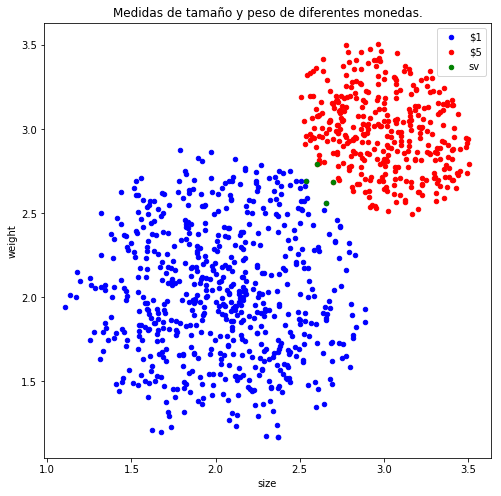

In [209]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax = dataset[dataset.type == '$1'].plot.scatter('size', 'weight', c='blue', ax=ax)
dataset[dataset.type == '$5'].plot.scatter('size', 'weight', c='red', ax=ax)
dataset[dataset.is_support].plot.scatter('size', 'weight', c='green', ax=ax)
ax.legend(['$1', '$5', 'sv'])
ax.set_title('Medidas de tamaño y peso de diferentes monedas.');

# Quadratic programing

A quadratic program (QP) is written in standard form as:

\begin{equation*}
\begin{array}{rl}
\mathrm{minimize} & (1/2) x^T P x + q^T x \\
\mathrm{subject\ to} & G x \leq h \\
    & A x = b
\end{array}
\end{equation*}

Here, $x$ is the vector of optimization variables $x_1,…,x_n$. The matrix $P$ and vector $q$ are used to define any quadratic objective function on these variables, while the matrix-vector couples $(G,h)$ and $(A,b)$ respectively define inequality and equality constraints. Vector inequalities apply coordinate by coordinate.

In [63]:
def cvxopt_solve_qp(P, q, G=None, h=None, A=None, b=None):
    P = .5 * (P + P.T)  # make sure P is symmetric
    args = [matrix(P), matrix(q)]
    if G is not None:
        args.extend([matrix(G), matrix(h)])
        if A is not None:
            args.extend([matrix(A), matrix(b)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return numpy.array(sol['x']).reshape((P.shape[1],))

## Recover our model

In [92]:
from cvxopt import matrix, solvers
Q = 2*matrix([ [2, .5], [.5, 1] ])
p = matrix([1.0, 1.0])
G = matrix([[-1.0,0.0],[0.0,-1.0]])
h = matrix([0.0,0.0])
A = matrix([1.0, 1.0], (1,2))
b = matrix(1.0)
Q, p, G, h, A, b
#sol=solvers.qp(Q, p, G, h, A, b)

(<2x2 matrix, tc='d'>,
 <2x1 matrix, tc='d'>,
 <2x2 matrix, tc='d'>,
 <2x1 matrix, tc='d'>,
 <1x2 matrix, tc='d'>,
 <1x1 matrix, tc='d'>)